# 以LSTM/GRU演算法预测股价
### 程式修改自[Predicting stock prices with LSTM](https://medium.com/neuronio/predicting-stock-prices-with-lstm-349f5a0974d4)

In [1]:
# 载入相关套件
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [39]:
# 载入测试资料 -- 亚马逊
df = pd.read_csv('./RNN/AMZN_2006-01-01_to_2018-01-01.csv', 
                 index_col='Date', parse_dates=['Date'])
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [40]:
df.tail()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2017-12-22,1172.08,1174.62,1167.83,1168.36,1585054,AMZN
2017-12-26,1168.36,1178.32,1160.55,1176.76,2005187,AMZN
2017-12-27,1179.91,1187.29,1175.61,1182.26,1867208,AMZN
2017-12-28,1189.00,1190.10,1184.38,1186.10,1841676,AMZN
2017-12-29,1182.35,1184.00,1167.50,1169.47,2688391,AMZN


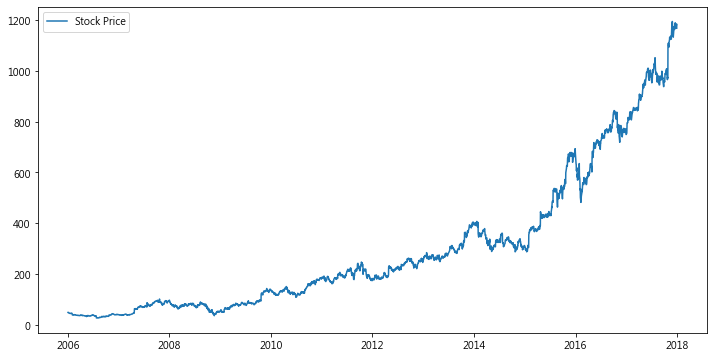

In [41]:
# 只使用收盘价
df = df['Close']

# 绘图
plt.figure(figsize = (12, 6))
plt.plot(df, label='Stock Price')
plt.legend(loc='best')
plt.show()

In [10]:
# 参数设定
look_back = 40    # 以过去 40 期为特征(X)
forward_days = 10 # 一次预测 10 天 (y)
num_periods = 20  # 测试资料量设定 20 期

In [11]:
# 特征常态化
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
array = df.values.reshape(df.shape[0],1)
array = scl.fit_transform(array)

In [12]:
# 前置处理函数，取得模型输入的格式
# look_back：特征(X)个数，forward_days：目标(y)个数，jump：移动视窗
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) - look_back - forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [14]:
# 资料切割成训练资料及测试资料
# 一次预测 10 天，共 20 期
division = len(array) - num_periods*forward_days

# 再往前推 40 天当第一笔的 X
array_test = array[division-look_back:]
array_train = array[:division]

In [15]:
# 前置处理、资料切割
# 测试资料前置处理，注意最后一个参数，一次预测 10天，不重叠
X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

# 训练资料前置处理
X,y = processData(array_train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

# 资料切割成训练资料及验证资料
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20)

In [16]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(2216, 40, 1)
(554, 40, 1)
(20, 40, 1)

(2216, 10)
(554, 10)
(20, 10)


In [17]:
# 训练模型
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 30
EPOCHS = 10

# 模型
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(forward_days))
model.compile(loss='mean_squared_error', optimizer='adam')

# 训练
history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate)
                    ,shuffle=True,batch_size=2, verbose=2)

Epoch 1/10
1108/1108 - 13s - loss: 0.0017 - val_loss: 3.0504e-04
Epoch 2/10
1108/1108 - 9s - loss: 4.1981e-04 - val_loss: 2.3948e-04
Epoch 3/10
1108/1108 - 9s - loss: 2.8643e-04 - val_loss: 4.7841e-04
Epoch 4/10
1108/1108 - 9s - loss: 3.5640e-04 - val_loss: 2.4681e-04
Epoch 5/10
1108/1108 - 9s - loss: 2.6637e-04 - val_loss: 1.8936e-04
Epoch 6/10
1108/1108 - 9s - loss: 2.7341e-04 - val_loss: 3.5231e-04
Epoch 7/10
1108/1108 - 9s - loss: 2.5290e-04 - val_loss: 1.6519e-04
Epoch 8/10
1108/1108 - 9s - loss: 2.3969e-04 - val_loss: 2.6758e-04
Epoch 9/10
1108/1108 - 9s - loss: 2.2914e-04 - val_loss: 1.8881e-04
Epoch 10/10
1108/1108 - 9s - loss: 2.1583e-04 - val_loss: 1.7120e-04


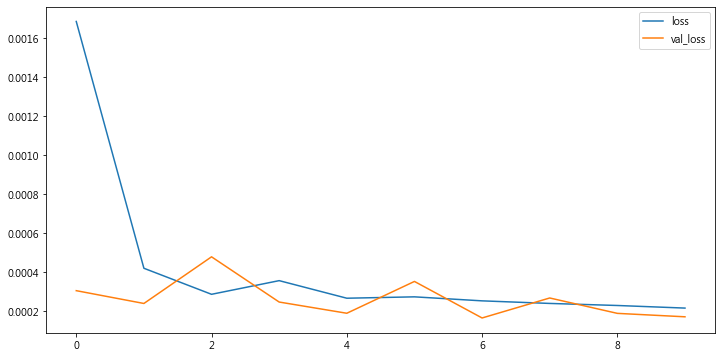

In [20]:
# 绘制损失函数
plt.figure(figsize = (12, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [21]:
model.save('./RNN/stock.h5')

## 一次预测 1天：jump=1

(200, 10)


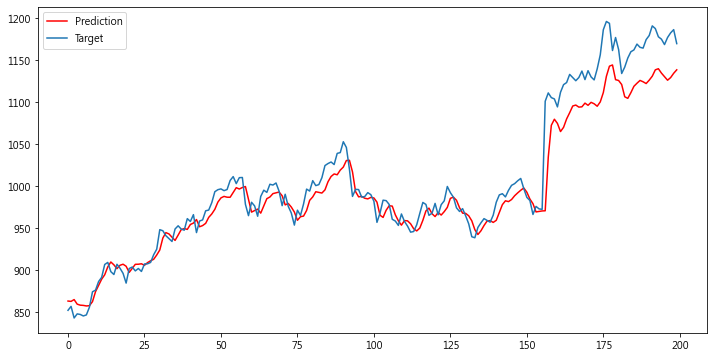

In [57]:
# 前置处理、资料切割
# 测试资料前置处理，注意最后一个参数，一次预测 1天
X_test,y_test = processData(array_test,look_back,1,1)
y_test = np.array([list(a.ravel()) for a in y_test])
        
# 测试资料预测
Xt = model.predict(X_test)
print(Xt.shape)

Xt = Xt[:, 0]

# 绘制测试资料预测值
plt.figure(figsize = (12, 6))
# 绘制 1 条预测值，scl.inverse_transform：还原常态化
plt.plot(scl.inverse_transform(Xt.reshape(-1,1)), color='r', label='Prediction')

# 绘制实际值
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()

In [58]:
# 测试资料前置处理，注意最后一个参数，一次预测 10天，移动视窗不重叠
X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

# 测试资料预测
Xt = model.predict(X_test)
Xt.shape

(20, 10)

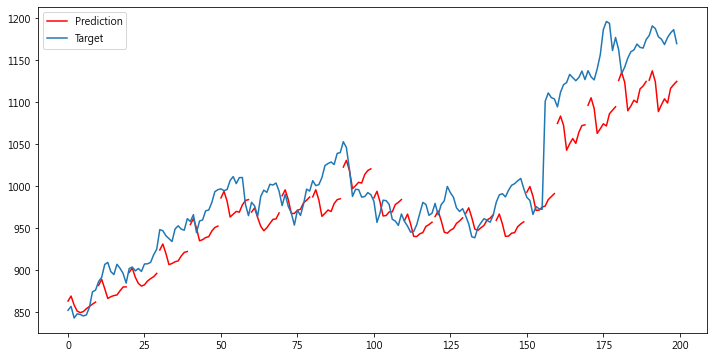

In [59]:
# 绘制测试资料预测值
plt.figure(figsize = (12, 6))
# 绘制 20 条预测值，scl.inverse_transform：还原常态化
for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], 
             scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')

# 指定预测值 label    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r'
         , label='Prediction') 

# 绘制实际值
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()

## 全部资料预测

In [32]:
# 全部资料预测
division = len(array) - num_periods*forward_days
array_test = array[division-look_back:]

# 去掉不能整除的资料，取完整的训练资料
leftover = division%forward_days+1
array_train = array[leftover:division]

Xtrain,ytrain = processData(array_train,look_back,forward_days,forward_days)
Xtest,ytest = processData(array_test,look_back,forward_days,forward_days)

# 预测
Xtrain = model.predict(Xtrain)
Xtrain = Xtrain.ravel() # 转成一维

Xtest = model.predict(Xtest)
Xtest = Xtest.ravel() # 转成一维

# 合并训练资料与测试资料
y = np.concatenate((ytrain, ytest), axis=0)

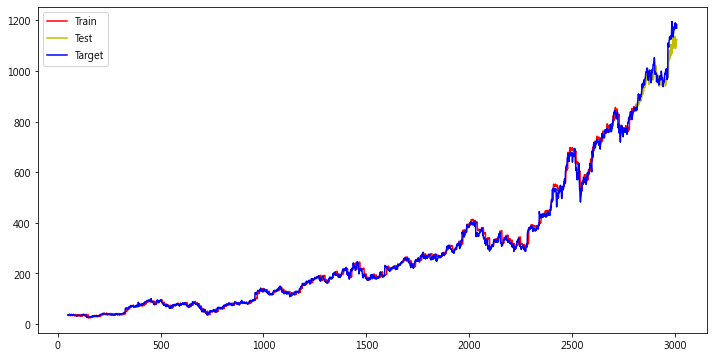

In [35]:
# 绘制训练资料预测值
plt.figure(figsize = (12, 6))
plt.plot([x for x in range(look_back+leftover, len(Xtrain)+look_back+leftover)], 
         scl.inverse_transform(Xtrain.reshape(-1,1)), color='r', label='Train')
# 绘制测试资料预测值
plt.plot([x for x in range(look_back +leftover+ len(Xtrain), 
         len(Xtrain)+len(Xtest)+look_back+leftover)], 
         scl.inverse_transform(Xtest.reshape(-1,1)), color='y', label='Test')

# 绘制实际值
plt.plot([x for x in range(look_back+leftover, 
                           look_back+leftover+len(Xtrain)+len(Xtest))], 
         scl.inverse_transform(y.reshape(-1,1)), color='b', label='Target')

plt.legend(loc='best')
plt.show()

## 看起来很好，可是拉近看

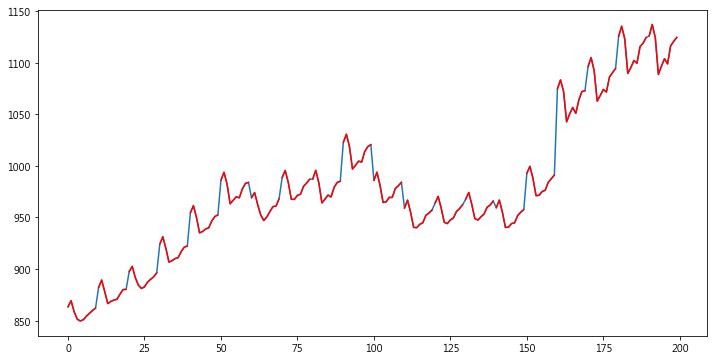

In [36]:
# 绘制测试资料预测值
plt.figure(figsize = (12, 6))
# 全部连成一线
plt.plot(scl.inverse_transform(Xtest.reshape(-1,1)))
# 画20条线
for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], 
             scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')

## 改用 GRU 模型

In [43]:
from tensorflow.keras.layers import GRU

model_GRU = Sequential()
model_GRU.add(GRU(NUM_NEURONS_FirstLayer,input_shape=(look_back,1)
                  , return_sequences=True))
model_GRU.add(GRU(NUM_NEURONS_SecondLayer
                  ,input_shape=(NUM_NEURONS_FirstLayer,1)))
model_GRU.add(Dense(forward_days))
model_GRU.compile(loss='mean_squared_error', optimizer='adam')

history = model_GRU.fit(X_train,y_train,epochs=EPOCHS
                    ,validation_data=(X_validate,y_validate)
                    ,shuffle=True,batch_size=2, verbose=2)

Epoch 1/10
1108/1108 - 11s - loss: 0.0010 - val_loss: 4.1804e-04
Epoch 2/10
1108/1108 - 8s - loss: 2.9304e-04 - val_loss: 2.2224e-04
Epoch 3/10
1108/1108 - 8s - loss: 2.7592e-04 - val_loss: 2.8546e-04
Epoch 4/10
1108/1108 - 8s - loss: 2.5116e-04 - val_loss: 1.5649e-04
Epoch 5/10
1108/1108 - 8s - loss: 2.5617e-04 - val_loss: 1.6422e-04
Epoch 6/10
1108/1108 - 8s - loss: 2.3559e-04 - val_loss: 2.5084e-04
Epoch 7/10
1108/1108 - 8s - loss: 2.1876e-04 - val_loss: 2.3458e-04
Epoch 8/10
1108/1108 - 8s - loss: 2.2160e-04 - val_loss: 2.3944e-04
Epoch 9/10
1108/1108 - 8s - loss: 2.1489e-04 - val_loss: 1.3484e-04
Epoch 10/10
1108/1108 - 8s - loss: 1.9979e-04 - val_loss: 1.7354e-04
